# KS & TPS data models training

In this notebook several Deep models are trained both on Kapton Substrate device's and on Tattoo Paper substrate device's data.

# Imports

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from itertools import cycle
from torch.optim.lr_scheduler import ExponentialLR
from sklearn import metrics
import seaborn as sns
from torchmetrics.classification import MulticlassF1Score


# Training Function

In [4]:
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val,class_weights, train_again = False, lr = 0.0001, lr_step = False):
    # loss function and optimizer
    loss_fn = nn.CrossEntropyLoss(weight = class_weights)  
    optimizer = optim.Adam(model.parameters(), lr= lr)
    
    if lr_step:
        lr_scheduler = ExponentialLR(optimizer, gamma = 0.99)

    if train_again:
        n_epochs = 1000 # number of epochs to run
        batch_size = 5  # size of each batch
    else:
        n_epochs = 500   
        batch_size = 10  
        
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable= True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                _, predicted = torch.max(y_pred, 1)
                F1 = (predicted == y_batch).float().mean()

                # lr_scheduler.step()
                
                bar.set_postfix(
                    loss=float(loss),
                    F1=float(F1)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        f1 = MulticlassF1Score(num_classes= 10) # calculates statistics for each label and computes weighted average using their support
        acc = f1(y_pred, y_val) * 100 
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/1000; F1 Score: {acc}; Loss: {loss}")
            
        if lr_step:
            lr_scheduler.step()
    # restore model with best weights and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

# Models

In [5]:
class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(20, 60)
        self.layer2 = nn.Linear(60, 60)
        self.layer3 = nn.Linear(60, 60)
        self.layer4 = nn.Linear(60, 60)
        
        self.act = nn.ReLU()
        self.output = nn.Linear(60, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.act(self.layer3(x))
        x = self.act(self.layer4(x))
        x = self.logsoftmax(self.output(x))
        return x

# Train deep model with entire data

In [2]:
TP_df = pd.read_csv('5datasets_13&14&17Jul.csv', sep = ';')
K_df = pd.read_csv('kapton_data.csv', sep = ';')

In [7]:
# Read data
normed_df = K_df.drop(columns = ['Time']).copy()
normed_TP_df = TP_df.copy()

for c in K_df.drop(columns = ['Time', 'AP']).columns:
    normed_df[c] = K_df[c] / K_df[c].abs().max()
    normed_TP_df[c] = TP_df[c] / TP_df[c].abs().max()
    
data = pd.concat((normed_df, normed_TP_df)).reset_index(drop = True)

y_all = data['AP']
X_all = data.drop(columns = ['AP'])

encoder = LabelEncoder()
encoder.fit(y_all)
y_all = encoder.transform(y_all)

# Convert to 2D PyTorch tensors
X_all = torch.tensor(X_all.values, dtype=torch.float32)
y_all = torch.tensor(y_all, dtype=torch.long)

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=0.8, shuffle=True)

In [8]:
data.shape

(5082, 21)

In [9]:
class_counts = torch.bincount(y)
data_size = len(y)

class_weights = data_size / (len(class_counts) * class_counts)
class_weights

tensor([0.1706, 2.2892, 2.7620, 2.0914, 2.0492, 2.0659, 2.2000, 2.0914, 2.1000,
        2.0828])

In [10]:
KTPM = Deep()

acc = model_train(KTPM, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights)
print(f"Achieved F1 Score: {acc:.2f}%")

Epoch 0/1000; F1 Score: 8.889307022094727; Loss: 2.116473913192749
Epoch 100/1000; F1 Score: 83.24114990234375; Loss: 0.07741831243038177
Epoch 200/1000; F1 Score: 88.24603271484375; Loss: 0.18276247382164001
Epoch 300/1000; F1 Score: 90.2769775390625; Loss: 0.09410171210765839
Epoch 400/1000; F1 Score: 90.71800994873047; Loss: 0.04759199172258377
Epoch 500/1000; F1 Score: 90.48736572265625; Loss: 0.03148142993450165
Epoch 600/1000; F1 Score: 91.39469146728516; Loss: 0.019981011748313904
Epoch 700/1000; F1 Score: 91.42821502685547; Loss: 0.016483085229992867
Epoch 800/1000; F1 Score: 90.90858459472656; Loss: 0.029172396287322044
Epoch 900/1000; F1 Score: 91.31596374511719; Loss: 0.022777695208787918
Achieved F1 Score: 92.01%


In [11]:
KTPM1 = Deep()

acc = model_train(KTPM1, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1e-3)
print(f"Achieved F1 Score: {acc:.2f}%")
torch.save(KTPM1, f'{round(acc)}_KTPM1.pth')

Epoch 0/1000; F1 Score: 53.41608428955078; Loss: 0.48158106207847595
Epoch 100/1000; F1 Score: 89.1561508178711; Loss: 0.023242317140102386
Epoch 200/1000; F1 Score: 91.29364776611328; Loss: 0.017886072397232056
Epoch 300/1000; F1 Score: 91.01718139648438; Loss: 0.03248809278011322
Epoch 400/1000; F1 Score: 89.6563491821289; Loss: 0.014626293443143368
Epoch 500/1000; F1 Score: 92.19738006591797; Loss: 0.012172950431704521
Epoch 600/1000; F1 Score: 89.84309387207031; Loss: 0.020053232088685036
Epoch 700/1000; F1 Score: 89.53875732421875; Loss: 0.017158612608909607
Epoch 800/1000; F1 Score: 90.1838150024414; Loss: 0.023820433765649796
Epoch 900/1000; F1 Score: 91.12663269042969; Loss: 0.010430893860757351
Achieved F1 Score: 93.01%


In [12]:
KTPM2 = Deep()

acc = model_train(KTPM2, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1.5e-3)
print(f"Achieved F1 Score: {acc:.2f}%")

Epoch 0/1000; F1 Score: 58.83497619628906; Loss: 0.4672631621360779
Epoch 100/1000; F1 Score: 89.44953918457031; Loss: 0.011682608164846897
Epoch 200/1000; F1 Score: 90.8560791015625; Loss: 0.010962743312120438
Epoch 300/1000; F1 Score: 89.085205078125; Loss: 0.014147168025374413
Epoch 400/1000; F1 Score: 90.62516784667969; Loss: 0.018178466707468033
Epoch 500/1000; F1 Score: 90.54795837402344; Loss: 0.00794307142496109
Epoch 600/1000; F1 Score: 89.55221557617188; Loss: 0.011974701657891273
Epoch 700/1000; F1 Score: 89.94992065429688; Loss: 0.016126206144690514
Epoch 800/1000; F1 Score: 90.01605987548828; Loss: 0.025852834805846214
Epoch 900/1000; F1 Score: 92.66284942626953; Loss: 0.014031024649739265
Achieved F1 Score: 93.27%


In [13]:
KTPM_expLR = Deep()

acc = model_train(KTPM_expLR, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1e-2, lr_step = True)
print(f"Achieved F1 Score: {acc:.2f}%")

Epoch 0/1000; F1 Score: 43.28030776977539; Loss: 0.46854421496391296
Epoch 100/1000; F1 Score: 88.91258239746094; Loss: 0.008339835330843925
Epoch 200/1000; F1 Score: 89.50888061523438; Loss: 0.0017633846728131175
Epoch 300/1000; F1 Score: 90.56439971923828; Loss: 0.005272206384688616
Epoch 400/1000; F1 Score: 90.28952026367188; Loss: 0.006323415786027908
Epoch 500/1000; F1 Score: 90.35366821289062; Loss: 0.004786836914718151
Epoch 600/1000; F1 Score: 89.7281265258789; Loss: 0.003928360063582659
Epoch 700/1000; F1 Score: 90.07019805908203; Loss: 0.0036756927147507668
Epoch 800/1000; F1 Score: 89.96957397460938; Loss: 0.003621074603870511
Epoch 900/1000; F1 Score: 89.99220275878906; Loss: 0.0036129076033830643
Achieved F1 Score: 91.36%


In [14]:
KTPM_expLR1 = Deep()

acc = model_train(KTPM_expLR1, X_train, y_train, X_test, y_test, train_again = True, class_weights = class_weights, lr = 1.5e-2, lr_step = True)
print(f"Achieved F1 Score: {acc:.2f}%")

torch.save(KTPM_expLR1, f'KTP models\\{round(acc)}_KTPM_expLR1.pth')

Epoch 0/1000; F1 Score: 43.85354995727539; Loss: 1.2255486249923706
Epoch 100/1000; F1 Score: 80.00824737548828; Loss: 0.2276582568883896
Epoch 200/1000; F1 Score: 85.18199157714844; Loss: 0.009353713132441044
Epoch 300/1000; F1 Score: 86.5460433959961; Loss: 0.0070536634884774685
Epoch 400/1000; F1 Score: 87.60794830322266; Loss: 0.006760039832442999
Epoch 500/1000; F1 Score: 87.67288208007812; Loss: 0.0068904934450984
Epoch 600/1000; F1 Score: 88.15316772460938; Loss: 0.00750014279037714
Epoch 700/1000; F1 Score: 88.24574279785156; Loss: 0.0075501082465052605
Epoch 800/1000; F1 Score: 88.06322479248047; Loss: 0.00763965118676424
Epoch 900/1000; F1 Score: 87.95555114746094; Loss: 0.007678529247641563
Achieved F1 Score: 88.48%


In [15]:
#KTPM = torch.load('KTP models\\88_KTPM.pth')
#KTPM1 = torch.load('KTP models\\90_KTPM1.pth')
#KTPM_expLR = torch.load('KTP models\\90_KTPM_expLR.pth')
#KTPM_expLR1 = torch.load('KTP models\\88_KTPM_expLR1.pth')

KTPM_models = {'KTPM': KTPM, 'KTPM1': KTPM1,'KTPM2': KTPM2, 'KTPM_expLR': KTPM_expLR, 'KTPM_expLR1': KTPM_expLR1}
KTPM_lrs = {'KTPM': 1e-4, 'KTPM1': 1e-3,'KTPM2': 1.5e-3, 'KTPM_expLR': 1e-2, 'KTPM_expLR1': 1.5e-2}

## Test 20th July data

In [4]:
df_20jul = pd.read_csv('20Jul.csv', sep = ';')

# Read data
df_20jul = df_20jul.drop(columns = ['time', 'Predicted AP']).copy()

for c in df_20jul.columns[:-1]:
    df_20jul[c] = df_20jul[c] / TP_df[c].abs().max()
    

y_20jul = df_20jul['AP']
X_20jul = df_20jul.drop(columns = ['AP'])

encoder = LabelEncoder()
encoder.fit(y_20jul)
y_20jul = encoder.transform(y_20jul)

# Convert to 2D PyTorch tensors
X_20jul = torch.tensor(X_20jul.values, dtype=torch.float32)
y_20jul = torch.tensor(y_20jul, dtype=torch.long)


In [12]:
TP_df['AP'].value_counts() / TP_df['AP'].value_counts().sum()

AP
0.0    0.527778
9.0    0.060185
3.0    0.053241
4.0    0.053241
5.0    0.053241
7.0    0.052083
8.0    0.051505
2.0    0.050926
6.0    0.049769
1.0    0.048032
Name: count, dtype: float64

In [15]:
df_20jul['AP'].value_counts() #/ df_20jul['AP'].value_counts().sum()

AP
0    121
4     29
8     19
1     18
2     15
3     15
7     13
5     10
6     10
9     10
Name: count, dtype: int64

Model KTPM with lr = 0.0001
F1 scores 
 - Test (20Jul): 75% 
 - Train: 94% 
 - Validation (y_test): 92%

CM for 20Jul data: 


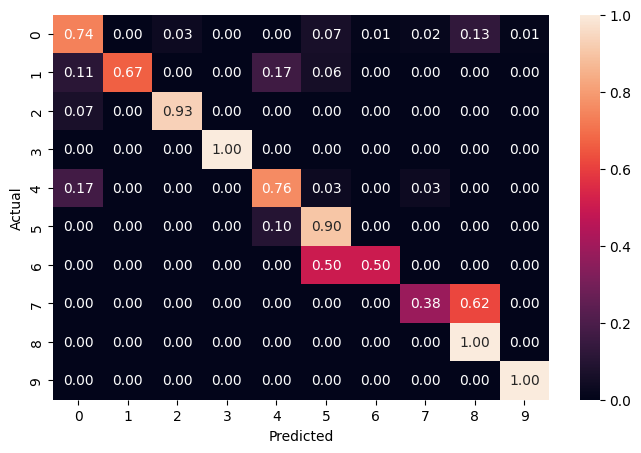

---------------------------------------------------------------------------------------------------

Model KTPM1 with lr = 0.001
F1 scores 
 - Test (20Jul): 78% 
 - Train: 95% 
 - Validation (y_test): 93%

CM for 20Jul data: 


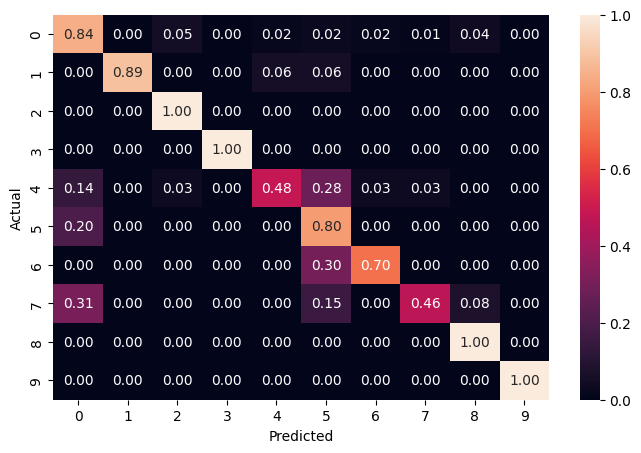

---------------------------------------------------------------------------------------------------

Model KTPM2 with lr = 0.0015
F1 scores 
 - Test (20Jul): 77% 
 - Train: 96% 
 - Validation (y_test): 93%

CM for 20Jul data: 


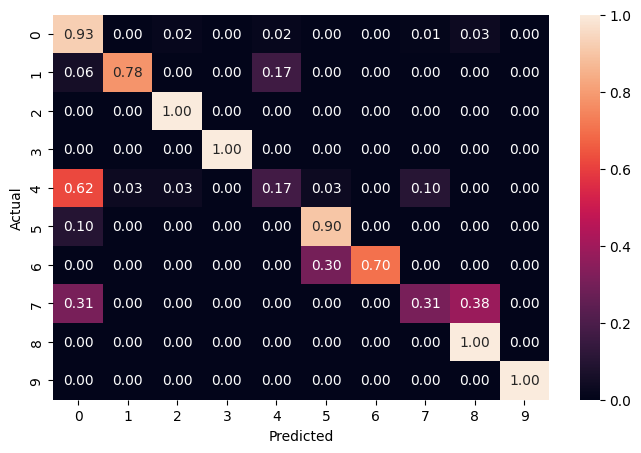

---------------------------------------------------------------------------------------------------

Model KTPM_expLR with lr = 0.01
F1 scores 
 - Test (20Jul): 66% 
 - Train: 97% 
 - Validation (y_test): 91%

CM for 20Jul data: 


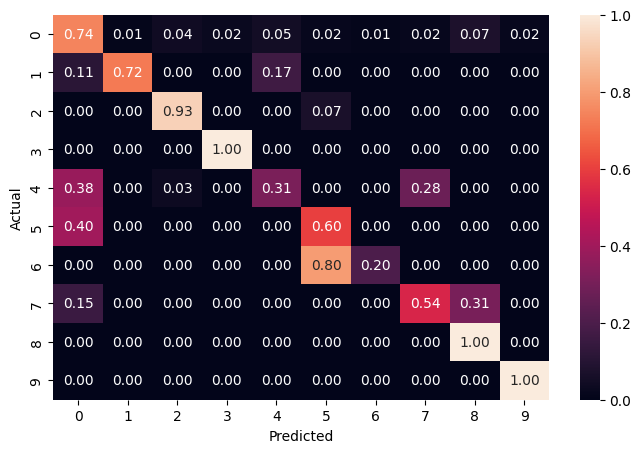

---------------------------------------------------------------------------------------------------

Model KTPM_expLR1 with lr = 0.015
F1 scores 
 - Test (20Jul): 70% 
 - Train: 94% 
 - Validation (y_test): 88%

CM for 20Jul data: 


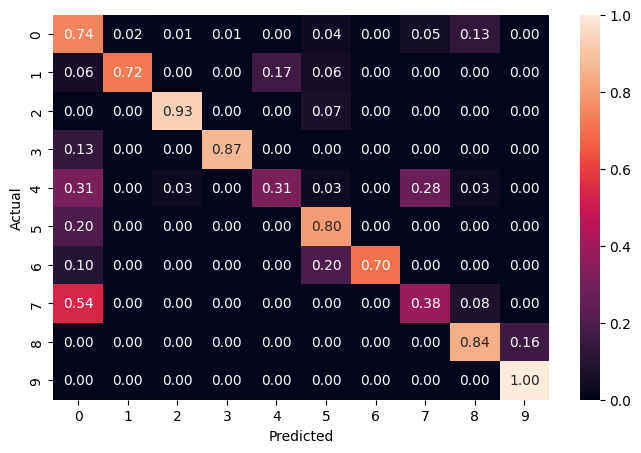

---------------------------------------------------------------------------------------------------



In [28]:
for m in KTPM_models.keys():
    torch.save(KTPM_models[m], f'{m}.pth')
    print(f"Model {m} with lr = {KTPM_lrs[m]}")
    y_pred = KTPM_models[m](X_20jul)
    y_train_pred = KTPM_models[m](X_train)
    y_test_pred = KTPM_models[m](X_test)

    f1 = MulticlassF1Score(num_classes= 10)
    print(f"F1 scores \n - Test (20Jul): {f1(y_pred, y_20jul).item() * 100:.0f}% \n - Train: {f1(y_train_pred, y_train).item() * 100:.0f}% \n - Validation (y_test): {f1(y_test_pred, y_test).item() * 100:.0f}%")

    _, predicted = torch.max(y_pred, 1)
    predicted = predicted.numpy()
    actual = y_20jul.numpy()

    cm = metrics.confusion_matrix(actual,  predicted)
    
    print("\nCM for 20Jul data: ")

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    plt.show()
    print('---------------------------------------------------------------------------------------------------\n')

Check single f1 scores

Model KTPM with lr = 0.0001
F1 scores 
 - Test (20Jul): tensor([0.8165, 0.8000, 0.8485, 1.0000, 0.8000, 0.5294, 0.6250, 0.4762, 0.6129,
        0.9524])% 
 - Train: tensor([0.9526, 0.9409, 0.9366, 0.9824, 0.9436, 0.9017, 0.9650, 0.9147, 0.8571,
        0.9666])% 
 - Validation (y_test): tensor([0.9385, 0.9318, 0.9762, 0.8941, 0.8730, 0.8760, 0.9278, 0.9580, 0.8824,
        0.9434])%

CM for 20Jul data: 


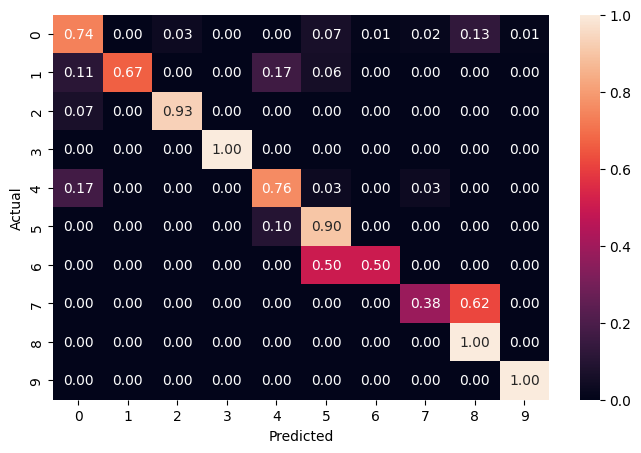

---------------------------------------------------------------------------------------------------

Model KTPM1 with lr = 0.001
F1 scores 
 - Test (20Jul): tensor([0.8755, 0.9412, 0.8108, 1.0000, 0.6087, 0.4571, 0.7000, 0.5714, 0.8636,
        1.0000])% 
 - Train: tensor([0.9680, 0.9669, 0.9167, 0.9801, 0.9738, 0.9548, 0.9756, 0.9405, 0.8889,
        0.9791])% 
 - Validation (y_test): tensor([0.9467, 0.9535, 0.9268, 0.9091, 0.9333, 0.8760, 0.9684, 0.9391, 0.8958,
        0.9524])%

CM for 20Jul data: 


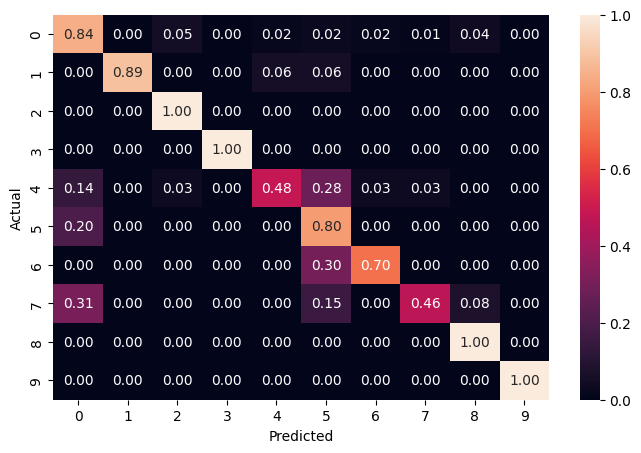

---------------------------------------------------------------------------------------------------

Model KTPM2 with lr = 0.0015
F1 scores 
 - Test (20Jul): tensor([0.8716, 0.8485, 0.9091, 1.0000, 0.2564, 0.7826, 0.8235, 0.3810, 0.8085,
        1.0000])% 
 - Train: tensor([0.9731, 0.9721, 0.9474, 0.9846, 0.9814, 0.9426, 0.9752, 0.9514, 0.8964,
        0.9737])% 
 - Validation (y_test): tensor([0.9576, 0.9111, 0.9882, 0.9048, 0.9244, 0.8739, 0.9263, 0.9655, 0.9247,
        0.9505])%

CM for 20Jul data: 


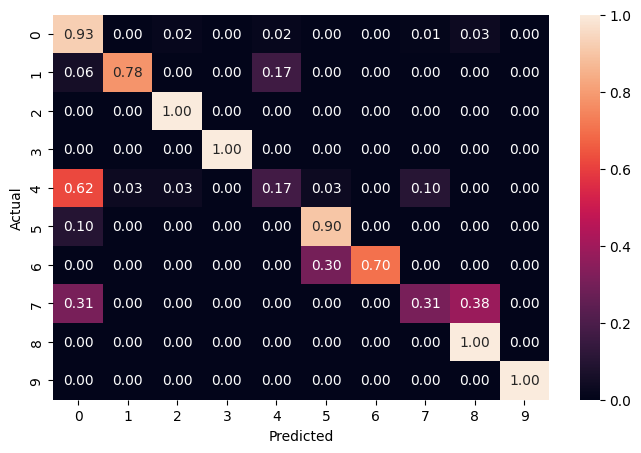

---------------------------------------------------------------------------------------------------

Model KTPM_expLR with lr = 0.01
F1 scores 
 - Test (20Jul): tensor([0.7826, 0.8125, 0.8000, 0.9091, 0.3830, 0.4444, 0.3077, 0.4667, 0.7451,
        0.9091])% 
 - Train: tensor([0.9758, 0.9674, 0.9492, 0.9924, 0.9742, 0.9770, 0.9783, 0.9496, 0.9193,
        0.9794])% 
 - Validation (y_test): tensor([0.9403, 0.9011, 0.9176, 0.9451, 0.8525, 0.8393, 0.9574, 0.9661, 0.8660,
        0.9505])%

CM for 20Jul data: 


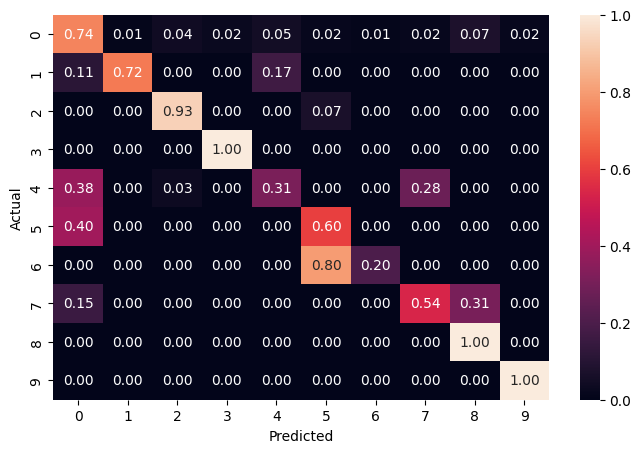

---------------------------------------------------------------------------------------------------

Model KTPM_expLR1 with lr = 0.015
F1 scores 
 - Test (20Jul): tensor([0.7725, 0.7879, 0.9032, 0.8966, 0.4390, 0.5714, 0.8235, 0.3125, 0.6038,
        0.8696])% 
 - Train: tensor([0.9555, 0.9607, 0.9416, 0.9848, 0.9581, 0.9078, 0.9431, 0.8985, 0.8584,
        0.9788])% 
 - Validation (y_test): tensor([0.9199, 0.8837, 0.9091, 0.9195, 0.8571, 0.8130, 0.9011, 0.9016, 0.8224,
        0.9200])%

CM for 20Jul data: 


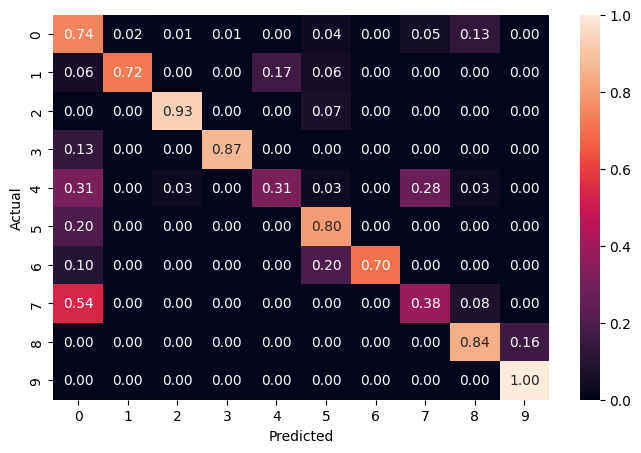

---------------------------------------------------------------------------------------------------



In [29]:
for m in KTPM_models.keys():
    #torch.save(KTPM_models[m], f'{m}.pth')
    print(f"Model {m} with lr = {KTPM_lrs[m]}")
    y_pred = KTPM_models[m](X_20jul)
    y_train_pred = KTPM_models[m](X_train)
    y_test_pred = KTPM_models[m](X_test)

    f1 = MulticlassF1Score(num_classes= 10, average = 'none')
    #print(f"F1 scores \n - Test (20Jul): {f1(y_pred, y_train).item() * 100:.0f}% \n - Train: {f1(y_train_pred, y_train).item() * 100:.0f}% \n - Validation (y_test): {f1(y_test_pred, y_test).item() * 100:.0f}%")
    print(f"F1 scores \n - Test (20Jul): {f1(y_pred, y_20jul)}% \n - Train: {f1(y_train_pred, y_train)}% \n - Validation (y_test): {f1(y_test_pred, y_test)}%")

    _, predicted = torch.max(y_pred, 1)
    predicted = predicted.numpy()
    actual = y_20jul.numpy()

    cm = metrics.confusion_matrix(actual,  predicted)
    
    print("\nCM for 20Jul data: ")

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.arange(0,10), yticklabels= np.arange(0,10))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    plt.show()
    print('---------------------------------------------------------------------------------------------------\n')